# Mini project 5 - Neural ODEs and Chaos

In the classwork (Wednesday 15th December 2021) we studied the basic `pydiffeq` example of fitting an ordinary differential equation.

In this project we are going to extend this to a more complicated differential equation - the Lorenz attractor. This is a three-dimensional ordinary differential equation, well known for being one of the most simple examples of a chaotic system. Edward Lorenz was a meteorologist, attempting to build a 2-dimensional model of the atmosphere, with heat transfer from below to above.

The system is challenging to model on a computer as for a wide range of the parameter space it exhibits chaos - infinitesimal variations in the input parameters amplify during time integration into entirely different regions of the parameter space (the 'butterfly effect', and the reason we cannot predict weather more than a few days in advance).

A small snippet of code implementing the Lorenz system is below. This should integrate with your Classwork notebook.
Note that you will need to adjust other parameters, particularly take care that the correct number of parameters (the Lorenz system is three dimensional, in class we studied a two dimensional spiral ODE) are being propagated through.

The 'Lorenz system' article on Wikipedia is actually quite detailed, for background and references to textbook solutions: https://en.wikipedia.org/wiki/Lorenz_system

For a quick (re)introduction to the numerical solution of ODEs, chapter 17 in the online version of Numerical Recipes is a good starting point: http://numerical.recipes/book/book.html It also has a practical 'cookbook' description of adapting an arbitary differential equation to a set of coupled first-order differential equations.

In [1]:
#  From https://scipython.com/blog/the-lorenz-attractor/
# Lorenz parameters and initial conditions.
sigma, beta, rho = 10, 2.667, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

NameError: name 'torch' is not defined

Using the adjoint method might increase solution speed / allow you to look at a larger region of parameter space, but there are restrictions on where it can be used:
    
`from torchdiffeq import odeint_adjoint as odeint`

# Tasks

* Implement the Lorenz system in a Neural ODE. 
* Learn the internal parameters.
* Attempt to predict the behaviour of the ODE beyond (in time) the training region.
* Study (and prepare results on) how accurate these learnt parameters are. 
 * Does the accuracy change when you operate the Lorenz system in a chaotic vs. trivial region of input parameters? (sigma, beta, rho in the function above)
 * Is it still accurate in a different region of phase space (i.e. changing the initial conditions for the ODE)?


* Comparison to direct neural-network time-series solution
 * Model some time series data (perhaps it would be easier to choose a 1D example) using a multi layer perceptron, 1D CNN or other neural network setup
 * Model this same data with an Neural ODE
 * How do the solutions compare? What are the pros and cons of the two different methods


* Look at other differential equations, such as the (chaotic) double pendulum, or the three-body gravitational problem discussed in the paper below.


This task list is neither exhaustive, nor is it necessary to do everything! Please spend a reasonable amount of time on this. Due to the remote teaching in the last sessions of term, it is more difficult to get a feel for how much progress people are making. 

Some of the methods discussed in the paper below may be of use.

https://arxiv.org/abs/1910.07291 
    
## Newton vs the machine: solving the chaotic three-body problem using deep neural networks
*Philip G. Breen, Christopher N. Foley, Tjarda Boekholt, Simon Portegies Zwart*
>Since its formulation by Sir Isaac Newton, the problem of solving the equations of motion for three bodies under their own gravitational force has remained practically unsolved. Currently, the solution for a given initialization can only be found by performing laborious iterative calculations that have unpredictable and potentially infinite computational cost, due to the system's chaotic nature. We show that an ensemble of solutions obtained using an arbitrarily precise numerical integrator can be used to train a deep artificial neural network (ANN) that, over a bounded time interval, provides accurate solutions at fixed computational cost and up to 100 million times faster than a state-of-the-art solver. Our results provide evidence that, for computationally challenging regions of phase-space, a trained ANN can replace existing numerical solvers, enabling fast and scalable simulations of many-body systems to shed light on outstanding phenomena such as the formation of black-hole binary systems or the origin of the core collapse in dense star clusters.


Imports:

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint

Set up true params and equations:

In [2]:
#  From https://scipython.com/blog/the-lorenz-attractor/
# Lorenz parameters and initial conditions.
sigma, beta, rho = 10, 2.667, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

Define training properties:

In [41]:
batch_time = 10
batch_size = 20
data_size = 1000
test_freq = 20

niters = 1000

viz = True

t = torch.linspace(0., 25., data_size).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values
true_y

tensor([[[ 0.0000,  1.0000,  1.0500]],

        [[ 0.2247,  1.0529,  0.9851]],

        [[ 0.4278,  1.2454,  0.9306]],

        ...,

        [[ 9.4671, 14.7670, 19.7274]],

        [[10.8097, 16.1635, 22.2666]],

        [[12.0994, 16.9408, 25.4477]]])

Define helpers:

In [42]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [43]:
def get_xyz(y_tensor, t_tensor):
    # use suvat s = ut + 1/2at**2 === ut neglecting resistive forces
    x, y, z = [],[],[]
    t_arr=t_tensor.cpu().numpy()
    u_arr = y_tensor.cpu().numpy()[:,0,0]
    v_arr = y_tensor.cpu().numpy()[:,0,1]
    w_arr = y_tensor.cpu().numpy()[:,0,2]
    dt = t_arr[1] - t_arr[0]
    dx = [u * dt for u in u_arr]
    dy = [v * dt for v in v_arr]
    dz = [z * dt for z in w_arr]
    for _dx, _dy, _dz in zip(dx, dy, dz):
        x.append(x[-1]+_dx if x else _dx)
        y.append(y[-1]+_dy if y else _dy)
        z.append(z[-1]+_dz if z else _dz)
    
    return np.array(x),np.array(y),np.array(z)


In [44]:
def visualize(true_y, pred_y, odefunc, itr):

    if viz:

        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_phase = fig.add_subplot(132, frameon=False)
        ax_vecfield = fig.add_subplot(133, frameon=False)

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'k-')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'm-')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'k--')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'm--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr)) # save plots to PNG folder
        plt.draw()
        plt.pause(0.001)

In [45]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def visualize(true_y, pred_y, odefunc, itr):
# Create an image of the Lorenz attractor.
# The maths behind this code is described in the scipython blog article
# at https://scipython.com/blog/the-lorenz-attractor/
# Christian Hill, January 2016.
# Updated, January 2021 to use scipy.integrate.solve_ivp.

    WIDTH, HEIGHT, DPI = 1000, 750, 100

    # Lorenz paramters and initial conditions.
    sigma, beta, rho = 10, 2.667, 28
    u0, v0, w0 = 0, 1, 1.05

    # Maximum time point and total number of time points.
    tmax, n = 100, 10000

    # Integrate the Lorenz equations.
    soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                    dense_output=True)
    # Interpolate solution onto the time grid, t.
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)

    # Plot the Lorenz attractor using a Matplotlib 3D projection.
    fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
    ax = fig.gca(projection='3d')
    ax.set_facecolor('k')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Make the line multi-coloured by plotting it in segments of length s which
    # change in colour across the whole time series.
    s = 10
    cmap = plt.cm.winter
    for i in range(0,n-s,s):
        ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

    # Remove all the axis clutter, leaving just the curve.
    ax.set_axis_off()

    plt.savefig('lorenz.png', dpi=DPI)
    plt.show()

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.gridspec import GridSpec

def visualize(true_vels, pred_vels, odefunc, losses, iterations):

    if viz:

        # #gs = GridSpec(2,3, figure=fig)
        # ax_traj = fig.add_subplot(gs[0,0], frameon=False)
        # ax_phase = fig.add_subplot(gs[0,1], projection='3d')
        # #ax_vecfield = fig.add_subplot(133, frameon=False)
        # #ax_loss = fig.add_subplot(gs[1,:], frameon=False)
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(141, frameon=False)
        ax_phase = fig.add_subplot(142, projection='3d')
        #ax_vecfield = fig.add_subplot(133, frameon=False)
        ax_loss = fig.add_subplot(144, frameon=False)

        true_x, true_y, true_z = get_xyz(true_vels, t)
        pred_x, pred_y, pred_z = get_xyz(pred_vels, t)
        
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y,z')
        ax_traj.plot(t.cpu().numpy(), true_x, 'k-', label='true x')
        ax_traj.plot(t.cpu().numpy(), true_y, 'm-', label='true y')
        ax_traj.plot(t.cpu().numpy(), true_z, 'b-', label='true z')
        ax_traj.plot(t.cpu().numpy(), pred_x, 'k--', label='predicted x')
        ax_traj.plot(t.cpu().numpy(), pred_y, 'm--', label='predicted y')
        ax_traj.plot(t.cpu().numpy(), pred_z, 'b--', label='predicted z')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        #ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.plot(true_x, true_y, true_z, 'g--', label="True")

        s=10
        n=len(t)
        line_segments = [(pred_x[i:i+s+1], pred_y[i:i+s+1], pred_z[i:i+s+1]) for i in range(0,n-s,s)]
        segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
        #lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
        #ax_phase.add_collection(lines)
        for i, line in enumerate(line_segments):
            ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

        #ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.set_zlabel('z')
        ax_phase.legend()

        
        # ax_phase.set_xlim(-2, 2)
        # ax_phase.set_ylim(-2, 2)

        # ax_vecfield.cla()
        # ax_vecfield.set_title('Learned Vector Field')
        # ax_vecfield.set_xlabel('x')
        # ax_vecfield.set_ylabel('y')

        # y, x = np.mgrid[-2:2:21j, -2:2:21j]
        # dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        # mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        # dydt = (dydt / mag)
        # dydt = dydt.reshape(21, 21, 2)

        # ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        # ax_vecfield.set_xlim(-2, 2)
        # ax_vecfield.set_ylim(-2, 2)

        ax_loss.plot(iterations, losses)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(iterations[-1])) # save plots to PNG folder
        plt.draw()
        plt.pause(0.001)

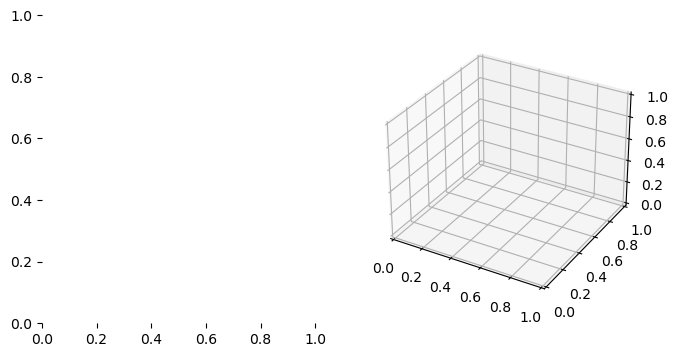

In [47]:
if viz:
    os.makedirs('png') if not os.path.exists('png') else None
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, projection='3d')
    #ax_vecfield = fig.add_subplot(133, frameon=False)
    #ax_loss = fig.add_subplot(144, frameon=False)
    plt.show(block=False)

# from matplotlib.gridspec import GridSpec

# if viz:
#     os.makedirs('png') if not os.path.exists('png') else None
#     import matplotlib.pyplot as plt
#     fig = plt.figure(figsize=(12, 4), facecolor='white')
#     gs = GridSpec(2,3, figure=fig)
#     ax_traj = fig.add_subplot(gs[0,0], frameon=False)
#     ax_phase = fig.add_subplot(gs[0,1], projection='3d')
#     #ax_vecfield = fig.add_subplot(133, frameon=False)
#     #ax_loss = fig.add_subplot(gs[1,:], frameon=False)
#     plt.show(block=False)

Define neural net:

In [69]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        # self.net = nn.Sequential(
        #     nn.Linear(3, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 3),
        # )

        # self.net = nn.Sequential(
        #     nn.Linear(3, 128),
        #     nn.Tanh(),
        #     nn.Linear(128, 128),
        #     nn.Tanh(),
        #     nn.Linear(128, 3),
        # )

        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

Main:

Iter 0020 | Total Loss 13.299659


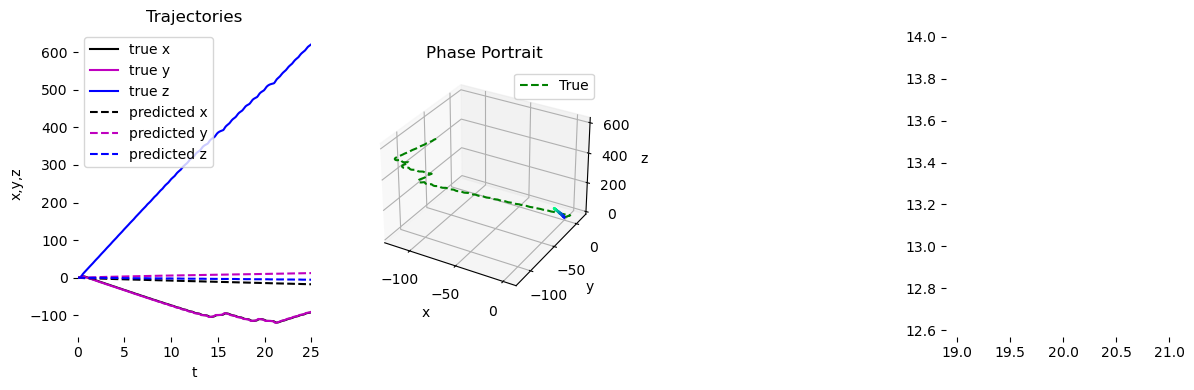

Iter 0040 | Total Loss 16.215271


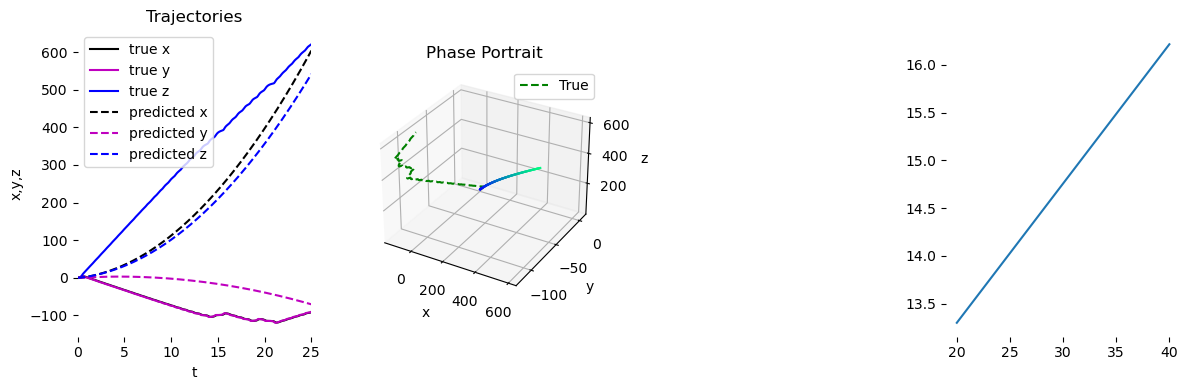

In [71]:
def main():
    iterations = []
    losses = []
    ii = 0

    func = ODEFunc().to(device)
    
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
    end = time.time()

    time_meter = RunningAverageMeter(0.97)
    
    loss_meter = RunningAverageMeter(0.97)

    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t).to(device)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                iterations.append(itr)
                losses.append(float(loss))
                
                visualize(true_y, pred_y, func, losses, iterations)
                ii += 1

        end = time.time()
    
    return func

finalfunc=main()
# Nb: plots are being saved to a png/niter subfolder, for if you want to include them in your lab report.


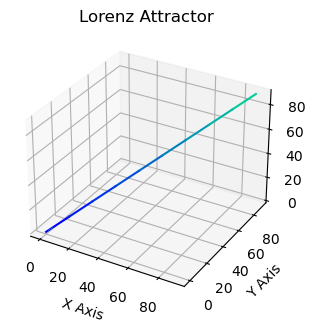

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 12), facecolor='white')
gs = GridSpec(2,3, figure=fig)
t_ax = fig.add_subplot(gs[0,0], projection='3d')

s=10
n=100
x = np.arange(0,100,1)
y = np.arange(0,100,1)
z = np.arange(0,100,1)

line_segments = [(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1]) for i in range(0,n-s,s)]
segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
for i, line in enumerate(line_segments):
    t_ax.plot(line[0], line[1], line[2], color = segment_colours[i])

t_ax.plot([1,2,3], [1,2,3], [1,2,3], lw=0.5)
t_ax.set_xlabel("X Axis")
t_ax.set_ylabel("Y Axis")
t_ax.set_zlabel("Z Axis")
t_ax.set_title("Lorenz Attractor")

plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm    
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Generate random data
np.random.seed(1)
n = 20 # number of data points
#set x,y,z data
x = np.random.uniform(0, 1, n)
y  = np.random.uniform(0, 1, n)
z = np.arange(0,n)

# Create a colormap for red, green and blue and a norm to color
# f' < -0.5 red, f' > 0.5 blue, and the rest green
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

#################
### 3D Figure ###
#################

# Create a set of line segments
points = np.array([x, y, z]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the 3D-line collection object
lc = Line3DCollection(segments, cmap=plt.get_cmap('copper'),
                    norm=plt.Normalize(0, n))
lc.set_array(z) 
lc.set_linewidth(2)

#plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim(0, max(z))
plt.title('3D-Figure')
ax.add_collection3d(lc, zs=z, zdir='z')

#save plot
plt.show()

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>